In [1]:
!pip install pydub

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pydub
from scipy import signal
import librosa
import librosa.display
import pickle

def get_samples(sound):
    channel_count = sound.channels
    if channel_count == 1:
        samples = np.array(sound.get_array_of_samples())
    elif channel_count == 2:
        sound_mono = sound.split_to_mono()
        samples = np.array(sound_mono[0].get_array_of_samples())
    else:
        raise Exception("More than 2 channels!")
    return samples

def plot_stft(t, f, dB, anchors=None):

    params = {'legend.fontsize': 'x-large','figure.figsize': (25, 6),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
    plt.rcParams.update(params)

    fig = plt.figure()
    plt.pcolormesh(t, f, dB, cmap='YlOrRd', shading='auto')
    fig.suptitle('Short-time Fourier transform (window duration 50ms, hopsize 10 ms)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.colorbar(format='%+02.0f dB')
    plt.ylim([0, 5])
    if anchors is not None:
        anchors_t, anchors_f = map(list, zip(*anchors))
        plt.scatter(anchors_t, anchors_f, marker='x', color='black')
    plt.show()
    
def generate_anchors(t, f, dB):
    delta_t = 0.1
    f_num_bands = 25

    t_rate = len(t) / (t[-1] - t[0])
    delta_i = int(delta_t * t_rate)
    if delta_i == 0:
        delta_i = 1
    delta_j = int(len(f) / f_num_bands)

    anchors_t = []
    anchors_f = []
    anchors = []

    for i in range(0, len(t) - delta_i, delta_i):
        for j in range(0, len(f) - delta_j, delta_j):
            tmp = dB[j:j+delta_j, i:i+delta_i]
            ind = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
            anchors_t.append(t[i + ind[1]])
            anchors_f.append(f[j + ind[0]])
            anchors.append((t[i + ind[1]], f[j + ind[0]]))
    
    return anchors

def generate_fingerprint(anchors):
    F = []
    t_offset = 0.1
    t_window = 0.5
    f_factors = (2**-0.5, 2**0.5)

    anchors.sort(key=lambda x: x[0])
    for t1, f1 in anchors:
        t_min = t1 + t_offset
        t_max = t1 + t_offset + t_window
        f_min = f1 * f_factors[0]
        f_max = f1 * f_factors[1]
        for t2, f2 in anchors:
            if t2 < t_min or t2 > t_max or f2 < f_min or f2 > f_max:
                continue
            h = (f1, f2, t2 - t1)
            F.append((t1, h))
    
    return F

def generate_matches(F1, F2):
    matches = []
    h_range = range(len(F1[0][1]))
    for t1, h1 in F1:
        for t2, h2 in F2:
            match = True
            for i in h_range:
                if h1[i] != h2[i]:
                    match = False
                    break
            if match:
                matches.append((t1, t2))
    return matches

def generate_num_of_matches(F1, F2):
    num_of_matches = 0
    h_range = range(len(F1[0][1]))
    for t1, h1 in F1:
        for t2, h2 in F2:
            match = True
            for i in h_range:
                if h1[i] != h2[i]:
                    match = False
                    break
            if match:
                num_of_matches = num_of_matches + 1
    return num_of_matches

def plot_matches(matches, self_compare=False):
    params = {'legend.fontsize': 'x-large','figure.figsize': (12, 12),
            'axes.labelsize': 'x-large','axes.titlesize':'x-large',
            'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    fig = plt.figure()
    matches_t1, matches_t2 = map(list, zip(*matches))
    plt.scatter(matches_t1, matches_t2, marker='x', color='black')
    plt.xlabel('Time in query signal (s)')
    if self_compare:
        plt.ylabel('Time in query signal (s)')
    else:
        plt.ylabel('Time in document signal (s)')
    plt.show()
    
def get_stft(snd_file, type = 0):
    if type == 0: sound = pydub.AudioSegment.from_file(snd_file, format="wav") 
    if type == 1: sound = pydub.AudioSegment.from_file(snd_file, format="m4a") 
    samples = get_samples(sound)
    duration = sound.duration_seconds
    window_ms = 50.0
    hop_ms = 10.0
    nperseg = (window_ms / 1000.0) * sound.frame_rate
    noverlap = ((window_ms - hop_ms) / 1000.0) * sound.frame_rate
    f, t, Zxx  = signal.stft(samples, fs = sound.frame_rate, window = 'hann', nperseg = nperseg, noverlap = noverlap, nfft = 50*4/1000*sound.frame_rate)
    f /= 1000.0
    dB = 20 * np.log10(np.abs(Zxx / abs(Zxx).max()))
    return t, f, dB

def get_fingerprint(snd_file, type = 0):
    t, f, dB = get_stft(snd_file, type)
    anchors = generate_anchors(t, f, dB)
    Fp = generate_fingerprint(anchors)
    return Fp

def generate_matches_new(F1, F2):
    F1_hashes = np.array(F1)[:,1]
    F2_hashes = np.array(F2)[:,1]
    matches, F1_index, F2_index = np.intersect1d(F1_hashes, F2_hashes, return_indices=True)
    #print(F1_index)
    F1_time = np.array(F1)[:,0]
    F2_time = np.array(F2)[:,0]
    n = F1_index.shape[0]
    match = []
    for i in range(n):
        t1 = F1_time[F1_index[i]]
        t2 = F2_time[F2_index[i]]
        match.append((t1, t2))
    return match

In [19]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [ ]:
"""
search result:
q2: bouba490
q5: bouba287
q6: kiki406
"""

In [5]:
f = open('query.pckl', 'rb')
F_q_arr_read = pickle.load(f)
f.close()
len(F_q_arr_read)

6

In [7]:
F_bouba490 = get_fingerprint("bouba_0490.wav", 0)
F_bouba287 = get_fingerprint("bouba_0287.wav", 0)
F_kiki406 = get_fingerprint("kiki_0406.wav", 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

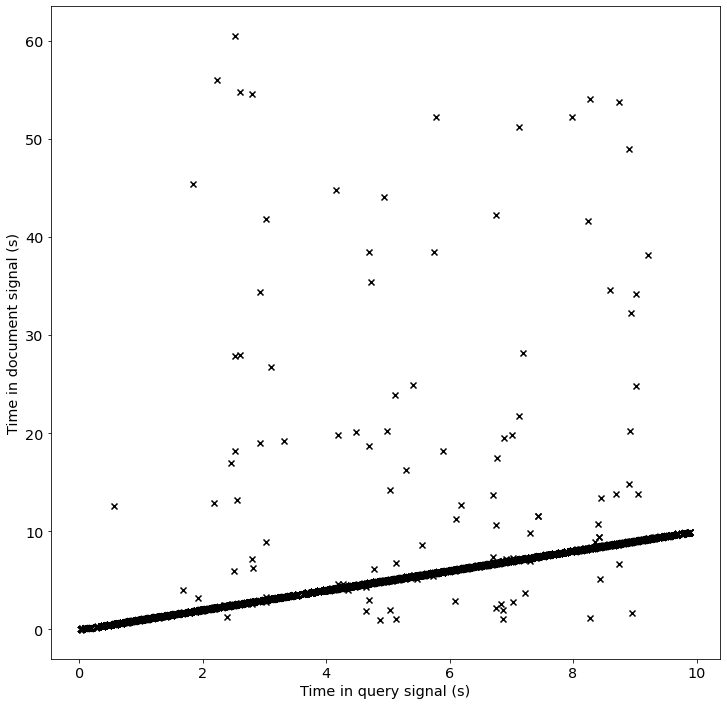

In [8]:
matches1 = generate_matches_new(F_q_arr_read[1], F_bouba490)
plot_matches(matches1)

(-0.4, 0.6)

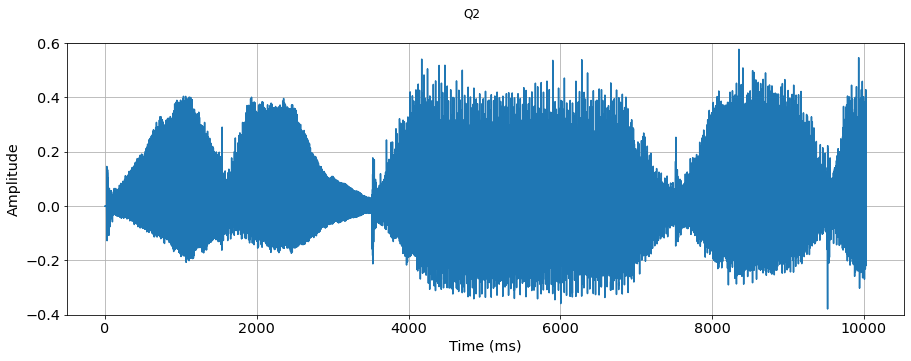

In [13]:
sound = pydub.AudioSegment.from_file("Q2.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('Q2')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.4, 0.6])

(0.0, 10000.0)

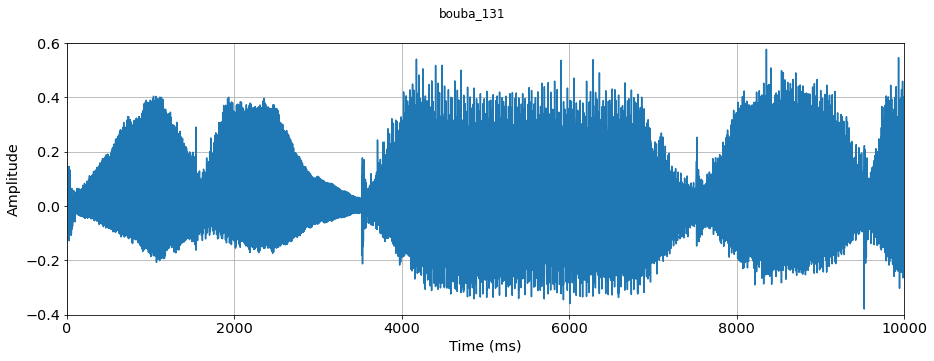

In [14]:
sound = pydub.AudioSegment.from_file("bouba_0490.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('bouba_490')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.4, 0.6])
plt.xlim([0, 10000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

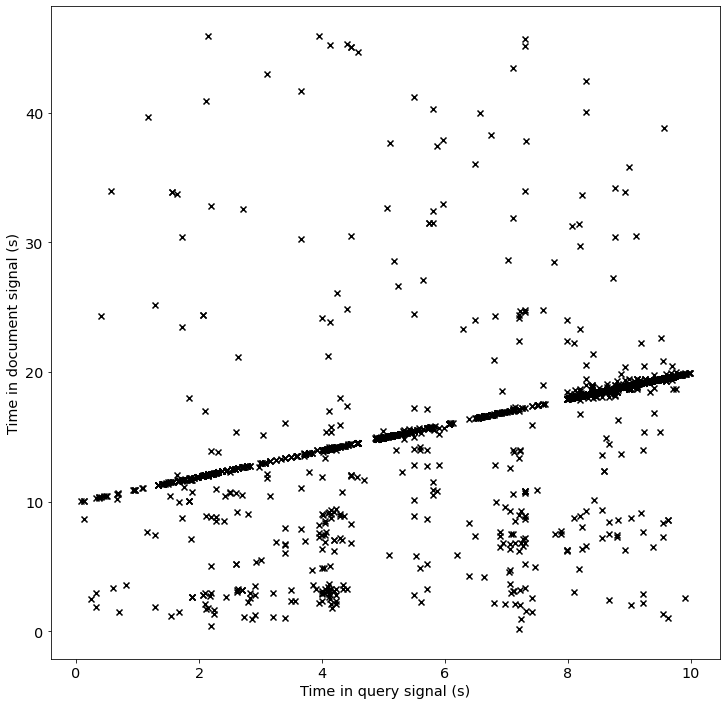

In [16]:
matches2 = generate_matches_new(F_q_arr_read[4], F_bouba287)
plot_matches(matches2)

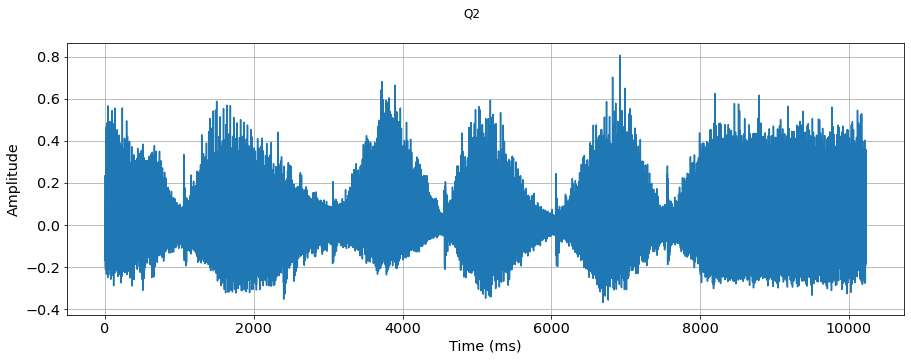

In [21]:
sound = pydub.AudioSegment.from_file("Q5.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('Q2')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.4, 0.8])

(10000.0, 20000.0)

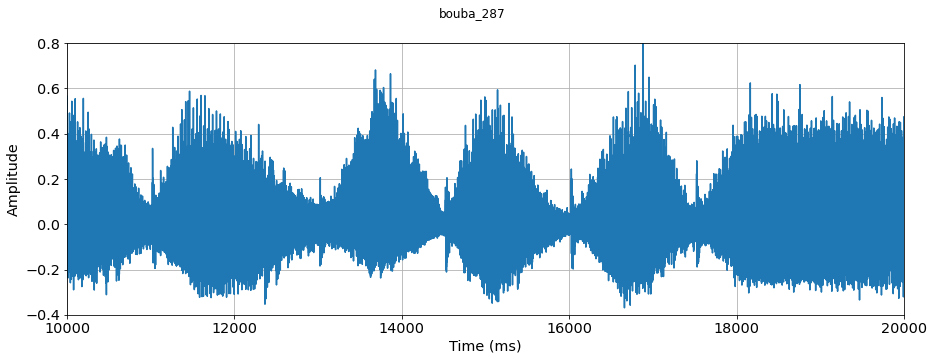

In [23]:
sound = pydub.AudioSegment.from_file("bouba_0287.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('bouba_287')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.4, 0.8])
plt.xlim([10000, 20000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

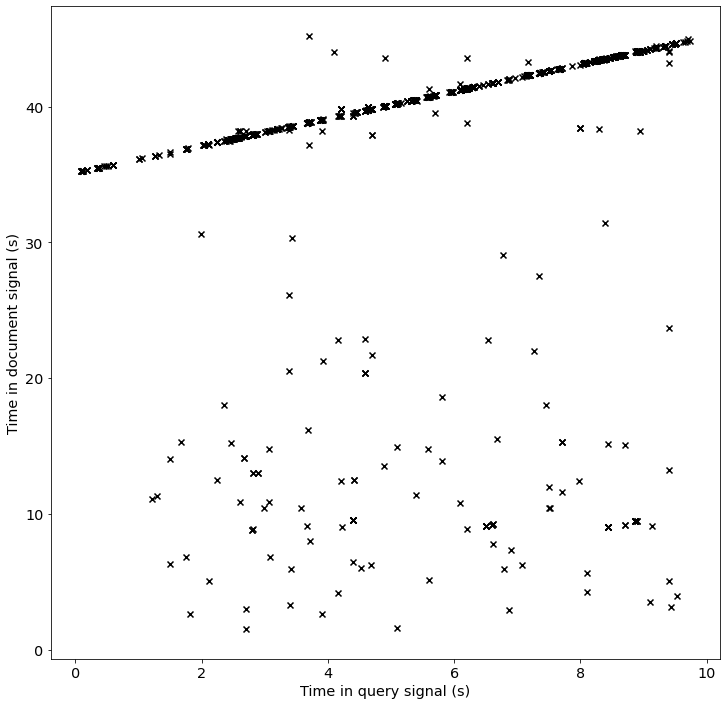

In [17]:
matches3 = generate_matches_new(F_q_arr_read[5], F_kiki406)
plot_matches(matches3)

(-0.6, 0.8)

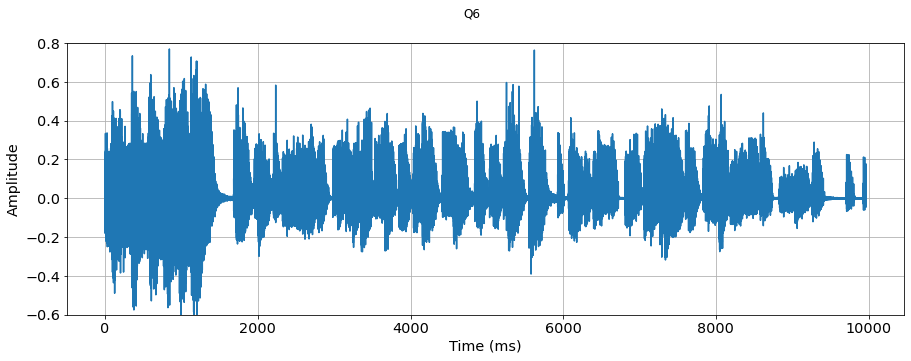

In [25]:
sound = pydub.AudioSegment.from_file("Q6.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('Q6')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.6, 0.8])

(35000.0, 46000.0)

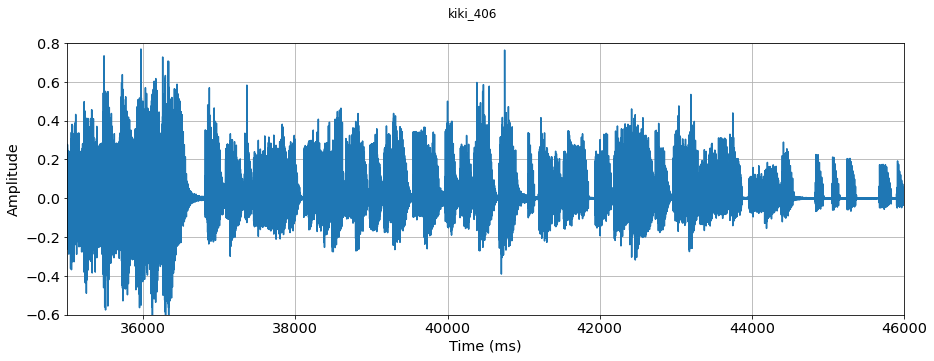

In [28]:
sound = pydub.AudioSegment.from_file("kiki_0406.wav", format="wav")
bit_rate = sound.sample_width * 8
frames_per_second = sound.frame_rate
duration = sound.duration_seconds * 1000 #sec to ms
channel_count = sound.channels
sound_mono = sound.split_to_mono()
samples_left = np.array(sound_mono[0].get_array_of_samples())
amplitude = samples_left / (2**bit_rate) * 2
time = np.arange(len(amplitude)) / len(amplitude) * duration

fig = plt.figure()
plt.plot(time, amplitude)
fig.suptitle('kiki_406')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim([-0.6, 0.8])
plt.xlim([35000, 46000])